In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

For examples of battery costs, see:
https://www.greenmatch.co.uk/blog/2018/07/solar-battery-storage-system-cost

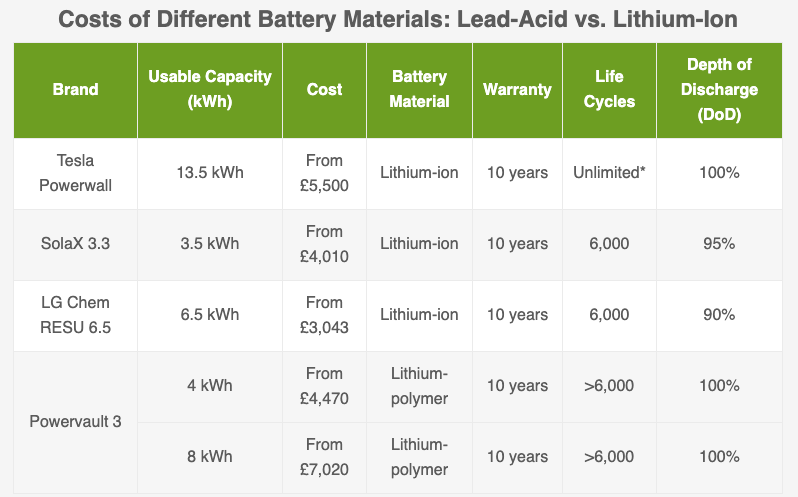

In [2]:
def control(P_sun, P_load, E_sto, dt, E_rated):
    """""
    P_sun: Generated power from PV (kW)
    P_load: Building load demand (kW)
    E_sto: Energy stored in the battery (kWh)
    dt: Derivate of time step (Hours)
    
    """""
    P_nl = P_load - P_sun # Net load -> Power needed by building from grid or battery (or combination)
    # outputs:
    P_sto = 0. # The power flowing into the battery (kW)
    P_grid = 0. # The power imported from the grid (kW)
    P_curt = 0. # The power exported to the grid (kW)
    
    E_next = E_sto - P_nl*dt # Energy stored in the battery at the end of current timestep (kWh)
    
    if P_nl>0: # (load > sun) -> Try to discharge the battery to the building load, if energy is available
        #TODO: Limit rate of discharge of battery
        E_next = E_next if E_next>0. else 0.
        P_sto = (E_next - E_sto)/dt # <0 # Calculate power flowing out of the battery
        P_grid = P_nl + P_sto # Calculate power taken from the grid as load power minus the batter discharge power
    else: # (load <= sun) -> Try to charge the battery
        E_next = E_next if E_next<E_rated else E_rated # Calculate battery charge state. Don't charge if full.
        P_sto = (E_next - E_sto)/dt # >0 # Calculate power flowing into the battery
        P_curt = -P_nl - P_sto#Calculate exported power: difference between net load and power flowing into battery
    return P_sto, P_grid, P_curt

## Method
#### ~~Select type of battery~~
#### ~~Get lifespan of battery~~
#### ~~Get install cost of battery~~
#### ~~Calculate amortized cost of battery per kWh per year~~
#### ~~Get cost of energy per kWh~~
#### ~~Choose initial and step size for battery (e.g. 1 kW with a step size of 0.5 kW)~~
#### ~~For each step size, calculate cost of battery plus cost of import~~
#### ~~Choose step size at which to run and stop optimisation~~
#### ~~Include export revenue~~
#### ~~Select step size with lowest total cost (optimal battery size)~~
#### Check optimisation results with a range of test loads

In [3]:
def amortize_batt_cost(cost_per_kwh, life_cycles):
    discharge_cycles_per_day = 1
    days_per_year = 365
    cycles_per_year = discharge_cycles_per_day * days_per_year
    _battery_life_years = life_cycles / cycles_per_year
    _amortized_battery_cost_kwh = cost_per_kwh / _battery_life_years
    return _amortized_battery_cost_kwh

In [4]:
def check_result(E_sto, E_rated, digits=3):
    """Check that battery charge is non-negative and not over capacity"""
    try:
        assert round( E_sto, digits ) >= 0.0, 'Battery charge state is negative'
        assert round ( E_sto, digits ) <= round( E_rated, digits ), 'Battery charge state is greater than capacity'
    except(AssertionError):
        print(f'E_sto: {E_sto}\tE_rated: {E_rated}')
        raise

In [5]:
def initialise_results_arrays(length, size, intial_charge_percent=50):
    P_sto = np.zeros(length)
    E_sto = np.zeros(length+1)
    P_grid = np.zeros(length)
    P_curt = np.zeros(length)
    E_sto[0]= ( intial_charge_percent / 100 ) * size
    return {'P_sto':P_sto, 'E_sto':E_sto, 'P_grid':P_grid, 'P_curt':P_curt}

In [6]:
def run_control(results, timestep, size, generation, _load, _dt):
    assert isinstance(results, dict)
    for k, v in results.items(): assert isinstance(v, np.ndarray)
        
    results['P_sto'][timestep], results['P_grid'][timestep], results['P_curt'][timestep] = \
        control(generation.values[timestep], _load.values[timestep], results['E_sto'][timestep], dt=_dt, E_rated=size)
    
    results['E_sto'][timestep+1] = results['E_sto'][timestep] + results['P_sto'][timestep] * _dt
    
    check_result( results['E_sto'][timestep+1], size )
    
    return results

In [7]:
def stop_or_continue(cost, prev_cost, keep_iterating):
    
    if prev_cost:
        diff_cost, prev_cost = cost - prev_cost, cost
    else:
        diff_cost, prev_cost = 0, cost
    
    keep_iterating = (keep_iterating+1) if  diff_cost <= 0 else (keep_iterating-1)

    return prev_cost, keep_iterating

In [8]:
def evaluate_results(results, amortized_battery_cost_kwh, batt_size, IMPORT_COST_KWH,
                     _generation, _load, export_price=0.04):
    results['E_sto'] = results['E_sto'][:-1]
    P_pv = _generation - results['P_curt']
    P_nl = _load - _generation

    battery_cost = batt_size * amortized_battery_cost_kwh
    grid_power = results['P_grid'].sum()
    export_power = results['P_curt'].sum()
    import_cost = grid_power * IMPORT_COST_KWH
    export_revenue = export_power * export_price
    total_cost = battery_cost + import_cost - export_revenue
    costs = {'batt_size':batt_size, 'battery_cost':battery_cost,
             'import_cost':import_cost, 'export_revenue':export_revenue,
             'total_cost':total_cost}
    print('.', end='', flush=True)
    return results, costs

In [30]:
def choose_battery_size(performace_data):
    return performace_data.total_cost.idxmin()

In [32]:
def plot_optimisation_curve(performace_data):
    ax = performace_data.plot(subplots=True, figsize=(10,5))

In [9]:
def simulate_battery_perfomance(load, generation, batt_cost, import_cost, timestep_hrs, export_price):
    rv = []
    size, prev_cost, keep_iterating = 0, 0, 1
    
    while keep_iterating:

        results = initialise_results_arrays(len(load), size)

        for hour in range(len(load)):
            results = run_control(results, hour, size, generation, load, timestep_hrs)

        results, costs = evaluate_results(results, batt_cost, size, import_cost, generation, load, export_price)
        
#         return results
    
        rv.append(costs)
            
        prev_cost, keep_iterating = stop_or_continue( costs['total_cost'], prev_cost, keep_iterating )

        size += 1
    
    return pd.DataFrame(rv).set_index('batt_size')

In [25]:
res = simulate_battery_perfomance(
    load = load_profiles.iloc[:,1],
    generation = load_profiles.iloc[:,0],
    batt_cost = amortize_batt_cost(cost_per_kwh=5_500/13.5, life_cycles=6000), #tesla powerwall
    import_cost = 0.14,
    timestep_hrs = 1,
    export_price = 0.04)

.....................

In [31]:
choose_battery_size(res)

9

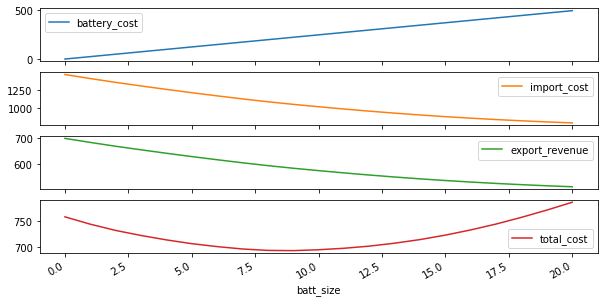

In [33]:
plot_optimisation_curve(res)

In [10]:
load_profiles = pd.read_pickle('examples/load_and_generation.pkl')
load_profiles = load_profiles.fillna(0)
load_profiles.sample()

,17.64_1kWp_generation_kWh,load_kWh,import_kWh,export_kWh
2019-10-14 03:00:00,7.619211,1.932962,0.0,-5.686249


.....................

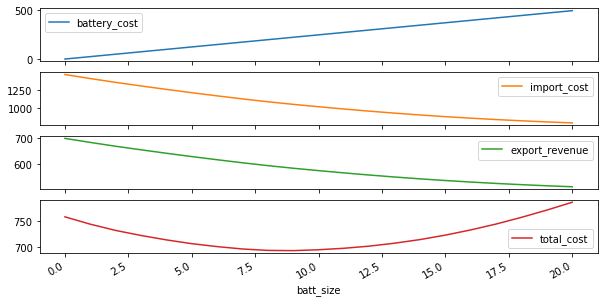

In [11]:
res = simulate_battery_perfomance(
    load = load_profiles.iloc[:,1],
    generation = load_profiles.iloc[:,0],
    batt_cost = amortize_batt_cost(cost_per_kwh=5_500/13.5, life_cycles=6000), #tesla powerwall
    import_cost = 0.14,
    timestep_hrs = 1,
    export_price = 0.04)
ax = res.plot(subplots=True, figsize=(10,5))

In [12]:
res.head()

,battery_cost,import_cost,export_revenue,total_cost
batt_size,,,,
0,0.000000,1455.904630,698.158359,757.746271
1,24.783951,1401.347857,682.590710,743.541098
2,49.567901,1349.854622,667.898357,731.524167
3,74.351852,1301.550448,654.117164,721.785136
4,99.135802,1254.986246,640.833106,713.288942


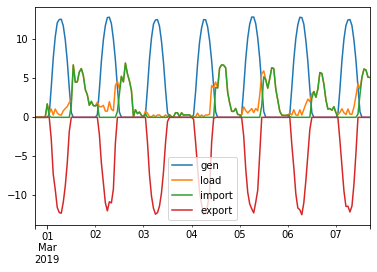

In [13]:
shifted = load_profiles.copy()
shifted.columns = ['gen', 'load', 'import', 'export']
shifted['load'] = shifted.load.shift(freq='6H')
shifted['import'] = ( shifted.load - shifted.gen ).clip(lower=0)
shifted['export'] = ( shifted.load - shifted.gen ).clip(upper=0)
shifted = shifted.fillna(0)
shifted[:24*7].plot()

...........................................

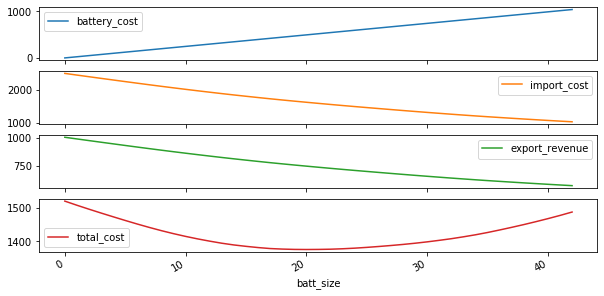

In [14]:
res = simulate_battery_perfomance(
    load = shifted.iloc[:,1],
    generation = shifted.iloc[:,0],
    batt_cost = amortize_batt_cost(cost_per_kwh=5_500/13.5, life_cycles=6000), #tesla powerwall
    import_cost = 0.14,
    timestep_hrs = 1,
    export_price=0.04)
ax = res.plot(subplots=True, figsize=(10,5))

In [15]:
res.head()

,battery_cost,import_cost,export_revenue,total_cost
batt_size,,,,
0,0.000000,2524.545653,1003.817434,1520.728220
1,24.783951,2472.636625,989.006283,1508.414293
2,49.567901,2421.406169,974.389010,1496.585060
3,74.351852,2370.614229,959.897027,1485.069054
4,99.135802,2320.261365,945.530494,1473.866673
